#Analiza sentymenty z wykorzystaniem BERT i zbioru Amazon Reviews
Dane karty graficznej:

In [31]:
##!nvidia-smi

Zainstalowane biblioteki:

In [32]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

numpy       : 1.19.2
pandas      : 1.2.4
torch       : 1.8.1
transformers: 4.5.1



Pobieranie zbioru danych i rozpakowywanie

In [42]:
!python -m wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz -o ./data/reviews.json.gz


Saved under ./data/reviews.json.gz


Importowane biblioteki:

In [54]:
import transformers
import pandas as pd
import gzip
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


Ładowanie danych:

In [43]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./data/reviews.json.gz')

Analiza danych:


In [49]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


In [50]:
df.shape


(296337, 9)

In [51]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 296337 entries, 0 to 296336
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      296337 non-null  object 
 1   asin            296337 non-null  object 
 2   reviewerName    294935 non-null  object 
 3   helpful         296337 non-null  object 
 4   reviewText      296337 non-null  object 
 5   overall         296337 non-null  float64
 6   summary         296337 non-null  object 
 7   unixReviewTime  296337 non-null  int64  
 8   reviewTime      296337 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 30.7+ MB


C:\Users\Parvex\anaconda3\envs\ZZSN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'review score')

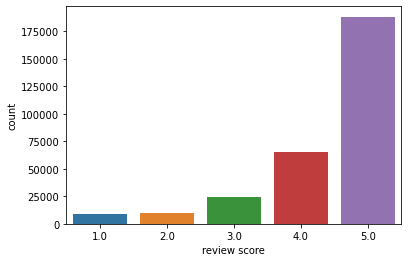

In [55]:
sns.countplot(df.overall)
plt.xlabel('review score')